<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase1/Experiments/GPT2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [28]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

gptModel = 'raygx/Nepali-GPT2-CausalLM'
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
gptModel = TFAutoModel.from_pretrained(gptModel)

# bertModel = 'Shushant/nepaliBERT'
# bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
# bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

gptModel.config

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/Nepali-GPT2-CausalLM.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


GPT2Config {
  "_name_or_path": "raygx/Nepali-GPT2-CausalLM",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_size": 50000
}

In [29]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [30]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [31]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [32]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.tokenizer.padding_side = 'left'
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trailing_context = trailing_context
    self.trainable=False

  def call(self, x):
    embeddings = self.embedding(
                  self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                )[0][:,-self.trailing_context:,:]

    return tf.reduce_logsumexp(embeddings,axis=1)

# class BERTEmbedding(tf.keras.layers.Layer):
#   def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
#     super().__init__()
#     self.embedding = model
#     self.tokenizer = tokenizer
#     self.max_token = max_token_len
#     self.padding = padding
#     self.truncation = truncation
#     self.trainable=False

#   def call(self, x):
#     return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

### Preparing Training Data

In [40]:
from tqdm.auto import tqdm

gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=1,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = gptEmbd(data['train'][i:i+batch]['text'])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 768)

In [41]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [42]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 8min 36s, sys: 722 ms, total: 8min 37s
Wall time: 8min 37s


array([0, 1, 2])

### Preparing Test Data

In [43]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = gptEmbd(data['test'][i:i+batch]['text'])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

## Evaluation

In [44]:
%%time
predictions = clf.predict(testX)

CPU times: user 2min 12s, sys: 179 ms, total: 2min 13s
Wall time: 2min 12s


In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.7350469970582907
Precision-Score 0.743770277700777
Recall-Score 0.7352268624383199
accuracy_Score 0.7352268624383199


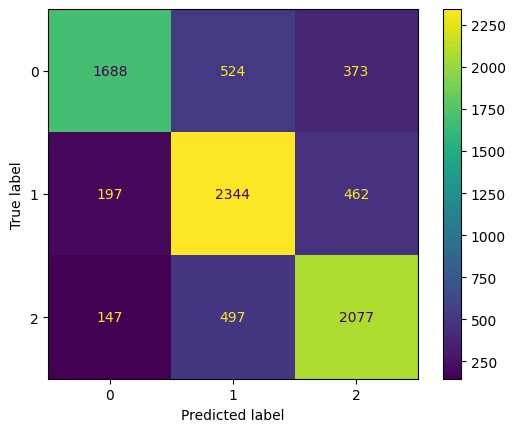

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()